In [39]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras.utils import plot_model
from keras import backend as K

import SegDataGenerator as gen

# can't run on GPU
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [15]:
data_path = 'data/dataset_256x256.npz'
model_path = 'models/multi-unet/'
learning_rate = 0.0001
batch_size = 1
img_height = 256
img_width = 256
img_channel = 1
steps_per_epoch=250
epochs=50
validation_step=20
color_mode = 'grayscale'

In [16]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)


In [17]:
def segmentation_loss_bk(y_true, y_pred):
    class_prop = 0.1638 
    weight_per_label = tf.scalar_mul(class_prop, tf.cast(tf.equal(y_true, 0), tf.float32)) + \
                        tf.scalar_mul(1.0 - class_prop, tf.cast(tf.equal(y_true, 1), tf.float32))
    cross_entropy = tf.losses.sigmoid_cross_entropy(y_true, y_pred)
    cross_entropy_weighted = tf.multiply(weight_per_label, cross_entropy)
    cross_entropy_mean = tf.reduce_mean(cross_entropy_weighted)
    return cross_entropy_mean

In [18]:
def segmentation_loss(y_true, y_pred):
    return tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred, labels=y_true)

In [19]:
def contour_loss_bk(y_true, y_pred):
    class_prop = 0.2249
    weight_per_label = tf.scalar_mul(class_prop, tf.cast(tf.equal(y_true, 0), tf.float32)) + \
                        tf.scalar_mul(1.0 - class_prop, tf.cast(tf.equal(y_true, 1), tf.float32))
    cross_entropy = tf.losses.sigmoid_cross_entropy(y_true, y_pred)
    cross_entropy_weighted = tf.multiply(weight_per_label, cross_entropy)
    cross_entropy_mean = tf.reduce_mean(cross_entropy_weighted)
    return cross_entropy_mean

In [20]:
def contour_loss(y_true, y_pred):
    return tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred, labels=y_true)

In [21]:
class Multi_UNet():
    def __init__(self, learning_rate, batch_size, img_height, img_width, img_channel):
        self.lr = learning_rate
        self.bs = batch_size
        self.height = img_height
        self.width = img_width
        self.channel = img_channel
        self.model = self.create_model()
    
    def ConvBlock(self, x, num_filter, conv_kernel_size=(3,3), dropout=0.2,
                  pool_size=(2,2), hasPool=True):
        conv = Conv2D(num_filter, conv_kernel_size, activation='elu', 
                      kernel_initializer='he_normal', padding='same') (x)
        conv = Dropout(dropout) (conv)
        conv = Conv2D(num_filter, conv_kernel_size, activation='elu', 
                      kernel_initializer='he_normal', padding='same') (conv)
        if hasPool == True:
            pool = MaxPooling2D(pool_size)(conv)
            return conv, pool
        return conv
    
    def DeConvBlock(self, x, cat, num_filter=16, conv_kernel_size=(3,3), up_size=(2,2), 
                    up_stride=(2,2), dropout=0.2, axis=-1):
        deconv = Conv2DTranspose(num_filter, up_size, strides=up_stride, padding='same') (x)
        deconv = concatenate([deconv, cat], axis=axis)
        conv = Conv2D(num_filter, conv_kernel_size, activation='elu', 
                      kernel_initializer='he_normal', padding='same') (deconv)
        conv = Dropout(dropout) (conv)
        conv = Conv2D(num_filter, conv_kernel_size, activation='elu', 
                    kernel_initializer='he_normal', padding='same') (conv)
        return conv
    
    
    def create_model(self):
        inputs = Input((self.height, self.width, self.channel,))
        
        # down-sampling
        conv1, pool1 = self.ConvBlock(inputs, 16, (3,3), 0.1, (2,2))
        conv2, pool2 = self.ConvBlock(pool1, 32, (3,3), 0.1, (2,2))
        conv3, pool3 = self.ConvBlock(pool2, 64, (3,3), 0.2, (2,2))
        conv4, pool4 = self.ConvBlock(pool3, 128, (3,3), 0.2, (2,2))
        conv5 = self.ConvBlock(pool4, 256, (3,3), 0.3, hasPool=False)
        
        # up-sampling
        conv6_s = self.DeConvBlock(conv5, conv4, 128, (3,3), (2,2), (2,2), 0.2)
        conv7_s = self.DeConvBlock(conv6_s, conv3, 64, (3,3), (2,2), (2,2), 0.2)
        conv8_s = self.DeConvBlock(conv7_s, conv2, 32, (3,3), (2,2), (2,2), 0.1)
        conv9_s = self.DeConvBlock(conv8_s, conv1, 16, (3,3), (2,2), (2,2), 0.1, axis=3)
        outputs_s = Conv2D(1, (1, 1), activation=None, name='segmentation') (conv9_s)
        
        conv6_c = self.DeConvBlock(conv5, conv4, 128, (3,3), (2,2), (2,2), 0.2)
        conv7_c = self.DeConvBlock(conv6_c, conv3, 64, (3,3), (2,2), (2,2), 0.2)
        conv8_c = self.DeConvBlock(conv7_c, conv2, 32, (3,3), (2,2), (2,2), 0.1)
        conv9_c = self.DeConvBlock(conv8_c, conv1, 16, (3,3), (2,2), (2,2), 0.1, axis=3)
        outputs_c = Conv2D(1, (1, 1), activation=None, name='contour') (conv9_c)
        
        model = Model(inputs=[inputs], outputs=[outputs_s, outputs_c])
        metrics = {'segmentation': [mean_iou], 'contour': [mean_iou]}
        loss = {'segmentation': segmentation_loss, 'contour': contour_loss}
        adam = optimizers.Adam(lr = self.lr)
        model.compile(optimizer=adam, loss=loss, loss_weights=[1.,1.], metrics=metrics)
        print(model.summary())
        
        return model


In [22]:
def plots(imgs, figsize=(12,6), rows=1, title=None, titles=None):
    f = plt.figure(figsize=figsize)
    if title is not None: plt.title(title)
    for i in range(len(imgs)):
        sp = f.add_subplot(rows, len(imgs)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=8)
        plt.imshow(np.squeeze(imgs[i]), cmap='gray')

In [ ]:
def evaluate(model):
    seg_thresh = 0.5
    contour_thresh = 0.4
    trainGenerator = gen.SegDataGenerator(validation_split=0.2)
    val_data = trainGenerator.flow_from_directory(data_path, subset='validation', batch_size=batch_size,
                                                   class_mode='segmentation', color_mode=color_mode,
                                                   use_contour=True)
    for i in range(20):
        print("visualize batch " + str(i))
        image, label = next(val_data)
        seg_gt = label['segmentation']
        contour_gt = label['contour']
        prediction = model.predict(image, batch_size=1)
        seg_pred = K.eval(K.sigmoid(prediction[0]))
        contour_pred = K.eval(K.sigmoid(prediction[1]))
        seg_pred_thresh = seg_pred > seg_thresh
        contour_pred_thresh = contour_pred > contour_thresh
        plots([image, seg_gt, contour_gt])
        plots([prediction[0], seg_pred_thresh, prediction[1], contour_pred_thresh])
    

In [ ]:
def main(args):
    TRAIN = False
    # define model
    multi_unet = Multi_UNet(learning_rate, batch_size, img_height, img_width, img_channel)
    model = multi_unet.model
#     plot_model(model, to_file='model.png')
    print("generate model!")
    
    # define generator
    if TRAIN == True:
        trainGenerator = gen.SegDataGenerator(validation_split=0.2,
                                             horizontal_flip=True, vertical_flip=True,
                                            elastic_transform=True, rotation_right=True,
                                            samplewise_center=False, samplewise_std_normalization=False)
        train_data = trainGenerator.flow_from_directory(data_path, subset='training', batch_size=batch_size,
                                                       class_mode='segmentation', color_mode=color_mode,
                                                       use_contour=True)
        val_data = trainGenerator.flow_from_directory(data_path, subset='validation', batch_size=batch_size,
                                                       class_mode='segmentation', color_mode=color_mode,
                                                       use_contour=True)
        print("get data generator!")

        # training
        if not os.path.exists(model_path):
            os.makedirs(model_path)
        checkpoint = ModelCheckpoint(model_path+'weight.{epoch:02d}.hdf5', monitor='val_loss',
                                     mode='min', period=1, save_best_only=True)

        print("start training!")
        model.fit_generator(train_data, steps_per_epoch=steps_per_epoch, epochs=epochs, 
                            callbacks=[checkpoint], validation_data=val_data, 
                            validation_steps=validation_step, shuffle=True)
        print("end training!")
        
    else:
        file_path = model_path + 'weight.50.hdf5'
        model.load_weights(file_path, by_name=False)
        print("load model!")
    
    # start evaluation and visualization
    evaluate(model)
    

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_547 (Conv2D)             (None, 256, 256, 16) 160         input_22[0][0]                   
__________________________________________________________________________________________________
dropout_274 (Dropout)           (None, 256, 256, 16) 0           conv2d_547[0][0]                 
__________________________________________________________________________________________________
conv2d_548 (Conv2D)             (None, 256, 256, 16) 2320        dropout_274[0][0]                
__________________________________________________________________________________________________
max_poolin

load model!
Reading from previously loaded data.
Found 134 images belonging to 2 classes.
visualize batch 0
[124]
visualize batch 1
[101]
visualize batch 2
[3]
visualize batch 3
[30]
visualize batch 4
[21]
visualize batch 5
[130]
visualize batch 6
[103]
visualize batch 7
[11]
visualize batch 8
[116]
visualize batch 9
[19]
visualize batch 10
[95]


/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


visualize batch 11
[47]
visualize batch 12
[57]
visualize batch 13
[70]
visualize batch 14
[40]
visualize batch 15
[126]
visualize batch 16
[105]
visualize batch 17
[76]
visualize batch 18
[14]
visualize batch 19
[128]


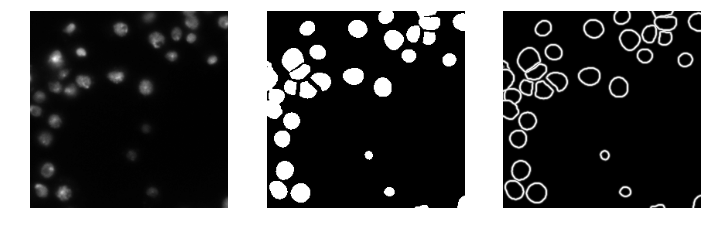

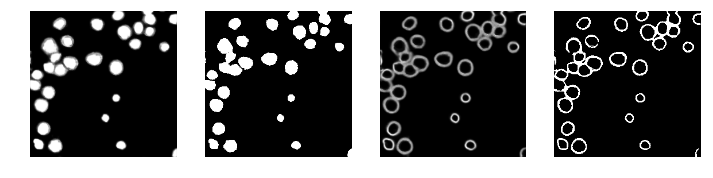

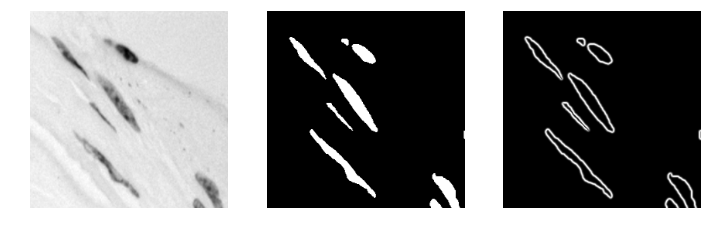

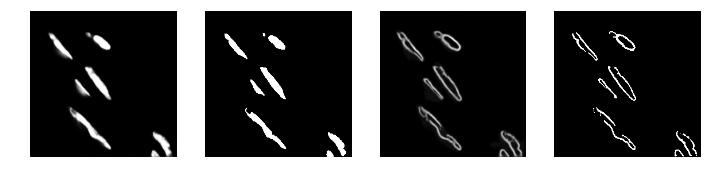

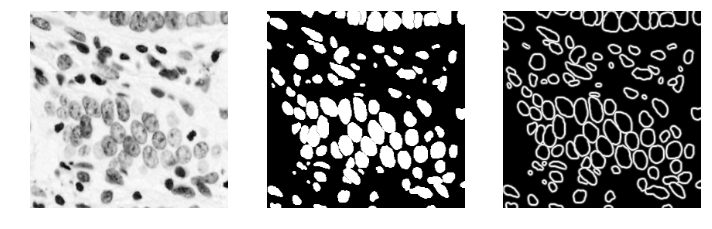

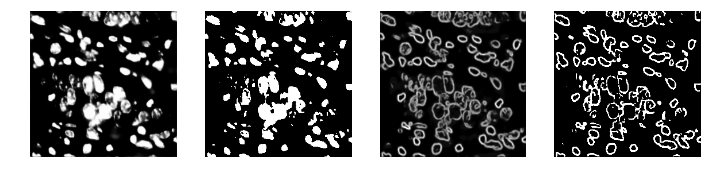

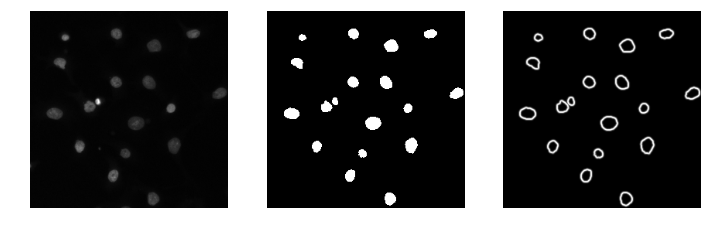

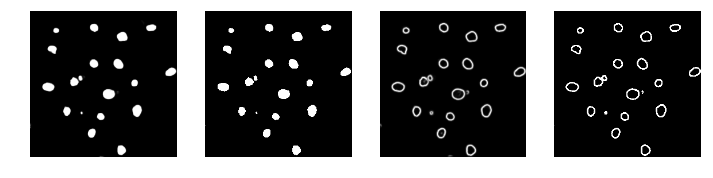

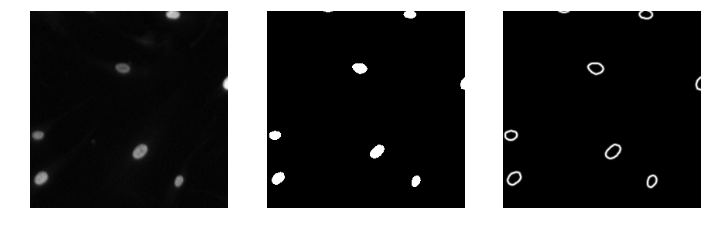

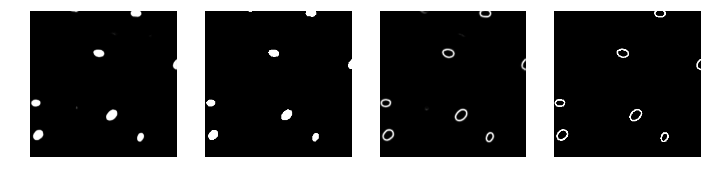

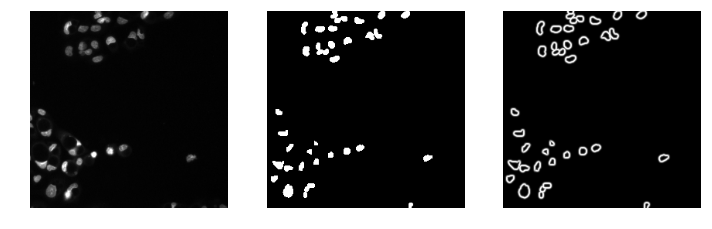

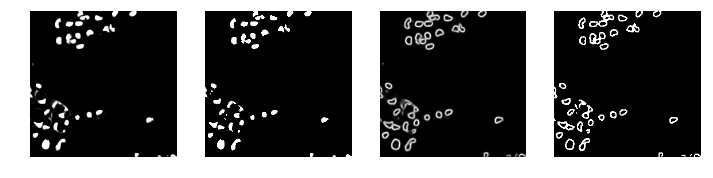

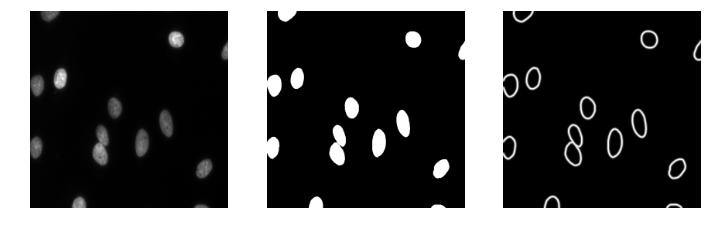

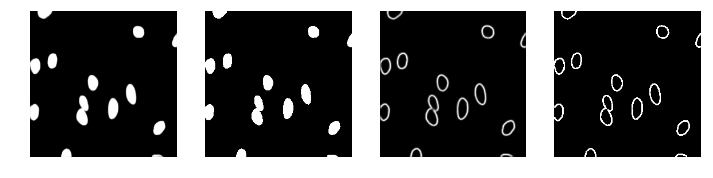

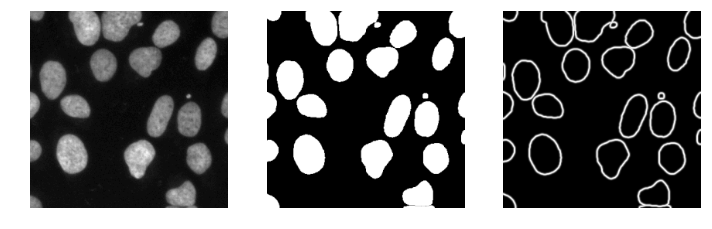

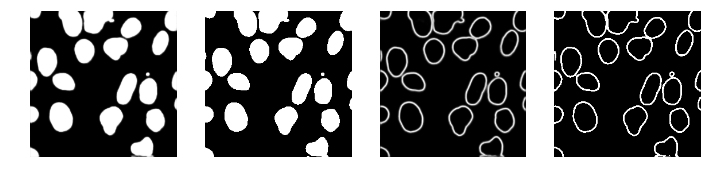

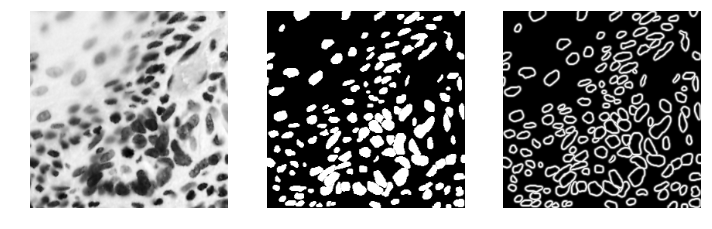

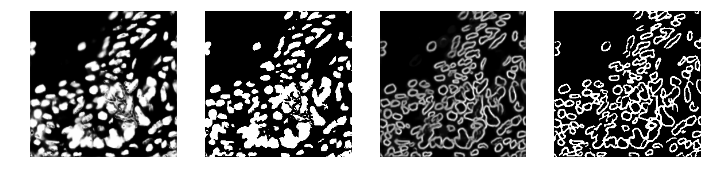

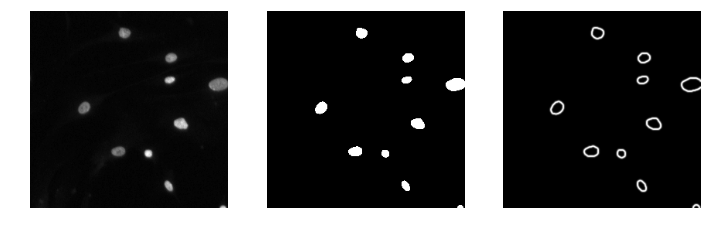

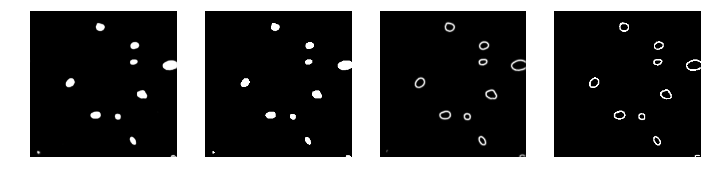

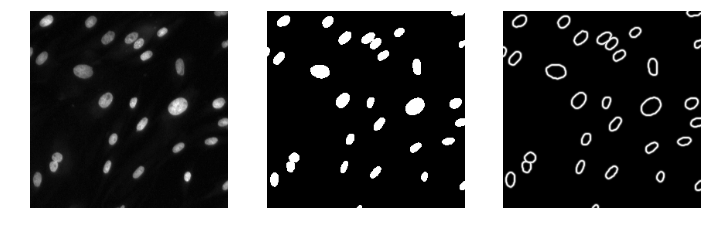

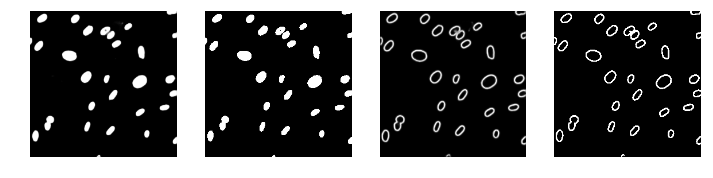

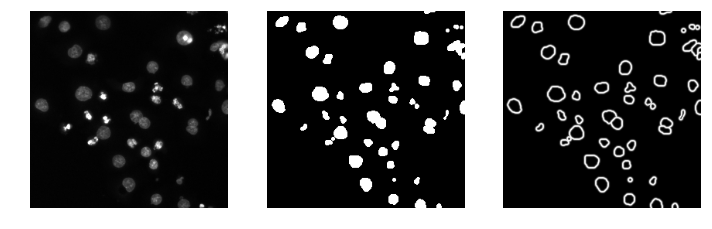

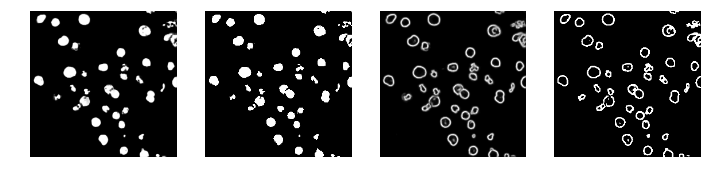

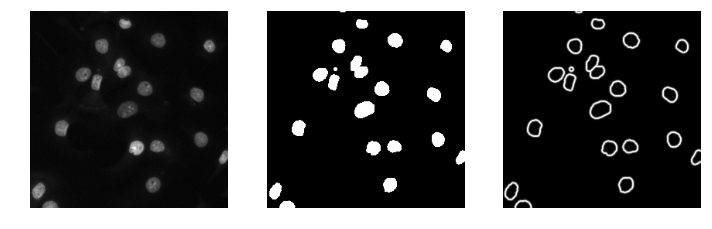

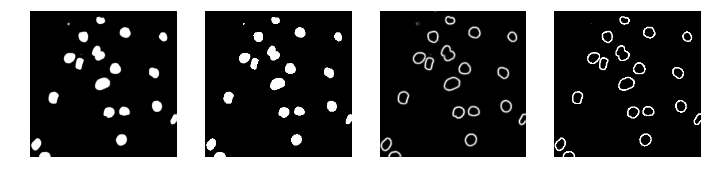

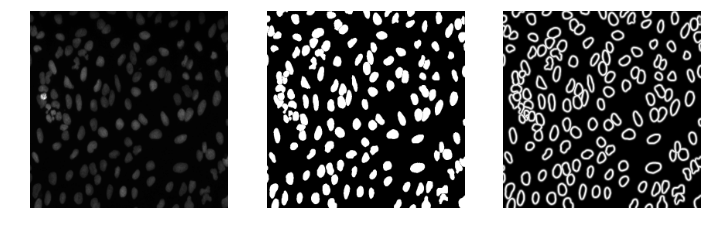

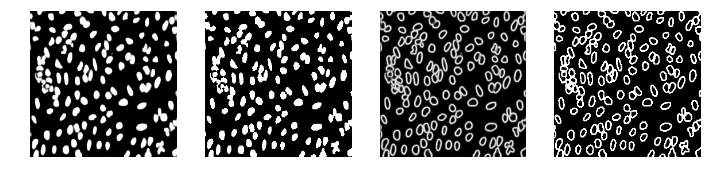

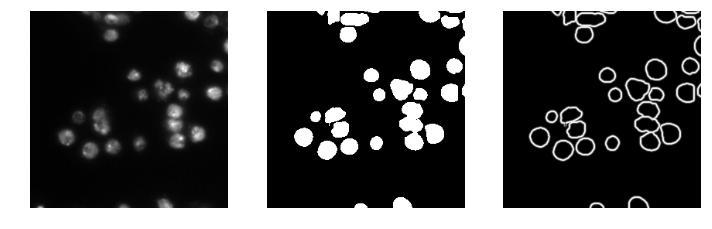

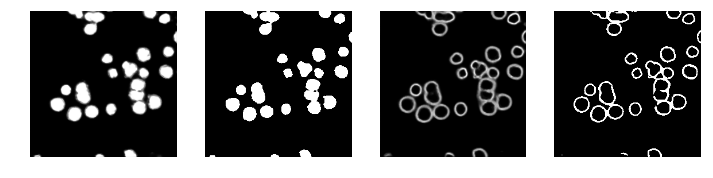

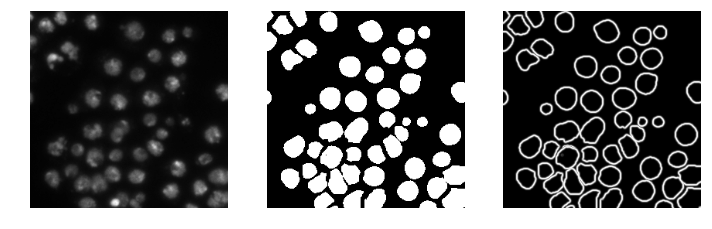

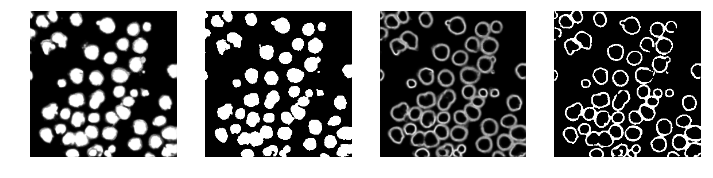

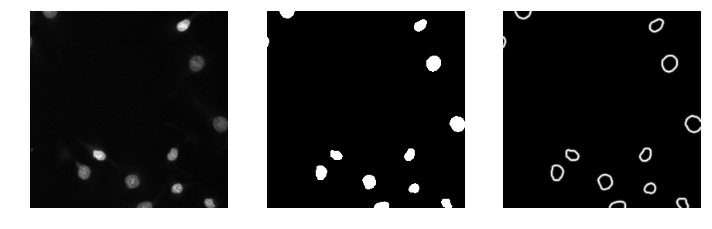

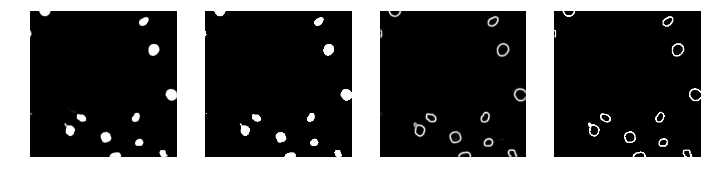

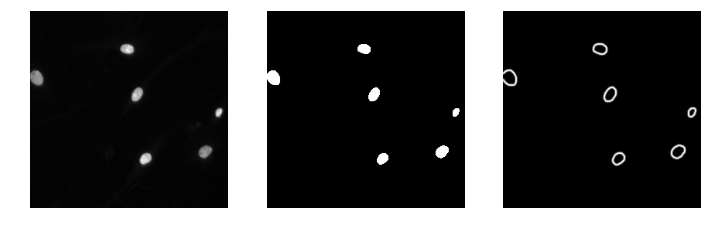

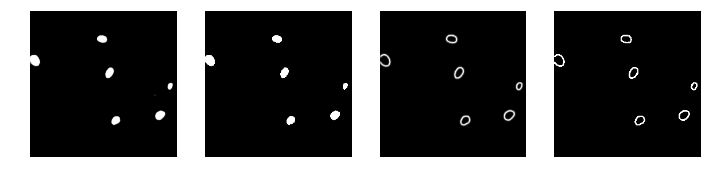

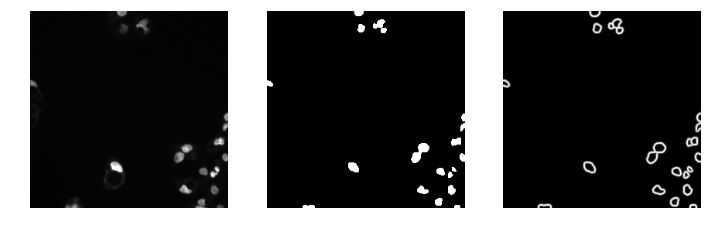

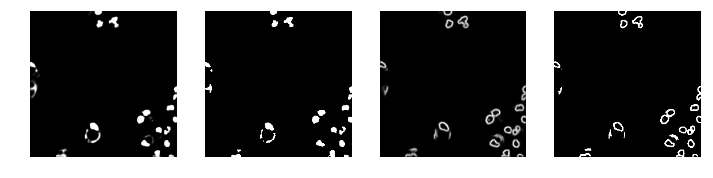

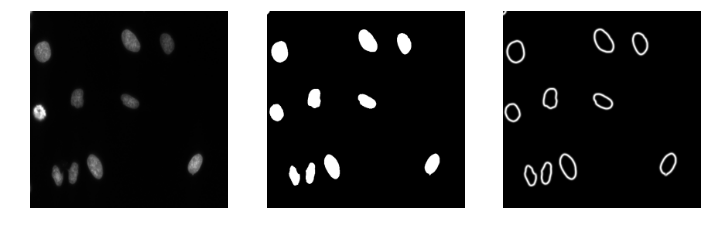

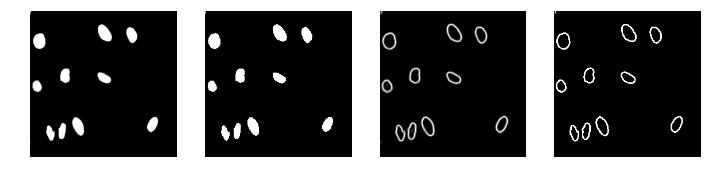

In [80]:
if __name__ == '__main__':
    main(sys.argv)